## Training the different Tic Tac Toe Players
In this notebook we will train and evaluate different players of the game Tic Tac Toe.

In [2]:
import matplotlib.pyplot as plt
from Players import RandomPlayer, MiniMaxPlayer, AlphaBetaPlayer, QPlayer, NeuralPlayer
from Game import TicTacToe

import numpy as np

In [7]:
def train(player1, player2, rounds=10, battles=10):
    game = TicTacToe(player1, player2)
    count, player1wins, player2wins, draws = game.train(rounds, battles)

    plt.figure(figsize=(12,7))
    plt.ylabel('Game outcomes in %')
    plt.xlabel('Game number')

    plt.plot(count, player1wins, 'g-', label='{} wins'.format(player1.name))
    plt.plot(count, player2wins, 'b-', label='{} wins'.format(player2.name))
    plt.plot(count, draws, 'r-', label='Draw')

    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.12), shadow=False, fancybox=True, framealpha=0.3, ncol=3)
    plt.show()

## 1. Random choice opponent

100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


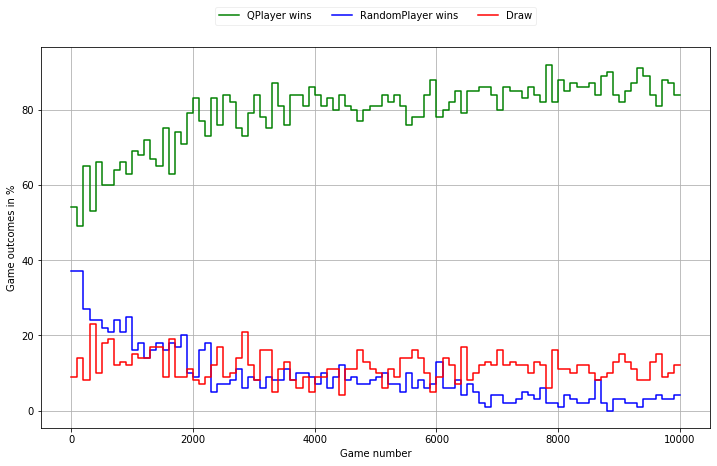

In [8]:
p1 = QPlayer(lr=0.9, lrdecay=0.95, exploration=0.1, explorationdecay=0.99)
p2 = RandomPlayer()

train(p1, p2, rounds=100, battles=10)

## 2. Minimax algorithm with $\alpha \beta$ - pruning

In [ ]:
p1 = QPlayer(lr=0.7, lrdecay=0.95, exploration=0.3, explorationdecay=0.95)
p2 = AlphaBetaPlayer()

p1.savePolicy()


train(p1, p2, rounds=50, battles=50)

 46%|████▌     | 23/50 [05:16<05:47, 12.88s/it]